In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout, LSTM, Activation

import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [0]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,OFF,UNT,NaN,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,OFF,TIN,IND,11,6
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,27,19
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,11,6
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,12,8


Dropping subtask a and c columns

In [0]:
data = data[(data['subtask_b'] == 'TIN') | (data['subtask_b'] == 'UNT')]
data.drop(columns  = ['subtask_a' , 'subtask_c'] , inplace  = True)
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_b,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,UNT,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,TIN,11,6
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,UNT,11,6
5,97670,@USER Liberals are all Kookoo !!!,liberals kookoo,1,0,0,0,TIN,6,2
6,77444,@USER @USER Oh noes! Tough shit.,oh noes tough shit,2,0,0,0,UNT,6,4


# Splitting Data: Train and Test


In [0]:
Y = data['subtask_b']
X = data.drop(['subtask_b','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (4400, 8)
Shape of Y:  (4400,)


In [0]:
data['subtask_b'].value_counts()

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [0]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (3080, 8)
Shape of Y_train:  (3080,)
Shape of X_test:  (1320, 8)
Shape of Y_test:  (1320,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(TIN=0, UNT=1))
Y_test = Y_test.map(dict(TIN=0, UNT=1))

# Making Data Model Ready: Encoding Tweets using GloVe Vectors (Pre-trained)


In [0]:
def get_embedding_matrix(tokenizer,vocab_size):
  '''
  Takes input a tokenizer trained on the training set and vocabulary size
  
  Returns glove vector encoding for each word in the vocabulary (300 dim)
  as embedding_matrix.
  '''

  with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

  embedding_matrix = np.zeros((vocab_size, 300))
  cnt=0
  for word, i in tokenizer.word_index.items():
    if word in glove_words:
      embedding_matrix[i] = model[word]
  return embedding_matrix

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['new_tweet'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ",vocab_size)

Vocabulary size:  6994


In [0]:
embedding_matrix_train = get_embedding_matrix(tokenizer,vocab_size)

In [0]:
print("Size of embedding matrix to be fed to RNN: ", embedding_matrix_train.shape)

Size of embedding matrix to be fed to RNN:  (6994, 300)


In [0]:
encoded_tweets_train = tokenizer.texts_to_sequences(X_train['new_tweet'])
encoded_tweets_test = tokenizer.texts_to_sequences(X_test['new_tweet'])

In [0]:
padded_tweets_train = pad_sequences(encoded_tweets_train,maxlen=100)
padded_tweets_test = pad_sequences(encoded_tweets_test,maxlen=100)

In [0]:
print("After padding train and test tweets: ")
print("padded train data:",padded_tweets_train.shape)
print("padded test data,", padded_tweets_test.shape)

After padding train and test tweets: 
padded train data: (3080, 100)
padded test data, (1320, 100)


#LSTM


In [0]:
#def build_model():
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=100, trainable=False)
#e = Embedding(input_dim = vocab_size, output_dim = 75, input_length=100)
model.add(e)
#model.add(Flatten())
model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          2097300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                12440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,109,751
Trainable params: 12,451
Non-trainable params: 2,097,300
_________________________________________________________________
None


In [0]:
# fit the model
model.fit(padded_tweets_train, Y_train.values, epochs=50)
# evaluate the model
loss, accuracy = model.evaluate(padded_tweets_train, Y_train.values)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/50
3080/3080 [==============================] - 8s 2ms/step - loss: 0.3776 - acc: 0.8808
Epoch 2/50
3080/3080 [==============================] - 7s 2ms/step - loss: 0.3705 - acc: 0.8808
Epoch 3/50
3080/3080 [==============================] - 8s 2ms/step - loss: 0.3655 - acc: 0.8808
Epoch 4/50
3080/3080 [==============================] - 7s 2ms/step - loss: 0.3618 - acc: 0.8802
Epoch 5/50
3080/3080 [==============================] - 7s 2ms/step - loss: 0.3514 - acc: 0.8802
Epoch 6/50
3080/3080 [==============================] - 7s 2ms/step - loss: 0.3419 - acc: 0.8818
Epoch 7/50
3080/3080 [==============================] - 7s 2ms/step - loss: 0.3421 - acc: 0.8821
Epoch 8/50
3080/3080 [==============================] - 7s 2ms/step - loss: 0.3363 - acc: 0.8815
Epoch 9/50
3080/3080 [==============================] - 7s 2ms/step - loss: 0.3264 - acc: 0.8838
Epoch 10/50
3080/3080 [==============================] - 7s 2ms/step - loss: 0.3180 - acc: 0.8864
Epoch 11/50
3080/3080 [======

In [0]:
def convert_prob_to_label(p,mean):
  if p >=mean:
    return 1
  return 0

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1163
           1       0.19      0.38      0.25       157

    accuracy                           0.74      1320
   macro avg       0.55      0.58      0.55      1320
weighted avg       0.82      0.74      0.77      1320



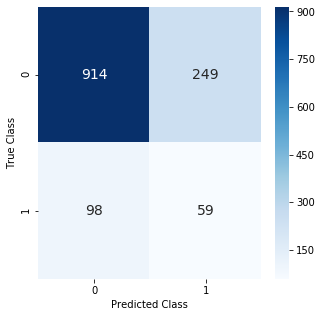

In [0]:
y_pred = model.predict(padded_tweets_test, batch_size=1)
mean1 = np.mean(y_pred)
y_pred_bool = [convert_prob_to_label(p,mean1) for p in y_pred]
print(classification_report(Y_test.values, y_pred_bool))
results = confusion_matrix(Y_test.values, y_pred_bool)
# plt.figure(figsize = (5,5))
# sns.heatmap(results, annot=True,annot_kws={"size": 10}, fmt='g')
# %matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()
# plt.figure(figsize = (5,5))
# sns.heatmap(results, annot=True,annot_kws={"size": 14}, fmt='g')

# sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')

In [0]:
f1_score(Y_test.values, y_pred_bool, average='macro')  

0.725947061346253

## Analysing Missclassified Tweets LSTM


In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_pred_bool)

In [0]:
print(len(misclassified[0]), 'misclassifications')

347 misclassifications


In [0]:
def print_stuff(idx):
  global y_pred # probabilities
  global X_test
  global y_test
  global y_pred_bool
  # preprocessed_tweet
  print('preprocessed tweet')
  print(X_test.iloc[idx,1])
  # computed prob
  print('computed prob: ',y_pred[idx], 'class predicted: ',y_pred_bool[idx])
  print('original class: ',y_test[idx])

In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 

In [0]:
limit = 5
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_pred_bool[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_pred_bool[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER He is way more creepier and says way more stupid things URL
 @USER @USER Bloodsport who can forget the monologue by jackson describing this big monster. and to think he is in his 60's now
 @USER Another overdose nigga:(
 @USER Everyone in Washington including John Heinz is being uncovered as the corrupt elites they are...Like cockroaches running from the light.
 @USER We are “Casually fucked”
 @USER Behold all the conservatives who deliberately ignore the fact that the OK gesture USED TO BE benign but now is co-opted by racists to signal they're down with white supremacy. Much like swastikas were benign in Asian countries (&amp; still are) but were co-opted &amp; ruined by Nazis.
 @USER the owner of my culo
 @USER @USER Because he is a traitor
 @USER @USER Funny how on top of things" you are trying to show you are when its white republicans in the path of the storm. An entire Island was just left to fend for its self for 13 days before help arrived.  Trump is a FAKE PRESIDENT"
 

# BiLSTM

In [0]:
from keras.layers import Input, Bidirectional, TimeDistributed

model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=100, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16))
model.add(Dropout(0.6))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          2098200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

In [0]:
# fit the model
model.fit(padded_tweets_train, Y_train.values, epochs=5)
# evaluate the model
loss, accuracy = model.evaluate(padded_tweets_train, Y_train.values)
print('Accuracy: %f' % (accuracy*100))



Epoch 1/5
3080/3080 [==============================] - 15s 5ms/step - loss: 0.5201 - acc: 0.7968
Epoch 2/5
3080/3080 [==============================] - 13s 4ms/step - loss: 0.4235 - acc: 0.8786
Epoch 3/5
3080/3080 [==============================] - 13s 4ms/step - loss: 0.3915 - acc: 0.8805
Epoch 4/5
3080/3080 [==============================] - 13s 4ms/step - loss: 0.3556 - acc: 0.8812
Epoch 5/5
3080/3080 [==============================] - 4s 1ms/step
Accuracy: 88.084416


In [0]:
y_pred = model.predict(padded_tweets_test, batch_size=1)
print(y_pred)

[[0.0970153 ]
 [0.18082207]
 [0.09315421]
 ...
 [0.03301533]
 [0.01260606]
 [0.10418874]]


In [0]:
y_pred_bool = [convert_prob_to_label(p,np.mean(y_pred)) for p in y_pred]
print(y_pred_bool)

[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      1163
           1       0.20      0.61      0.30       157

    accuracy                           0.66      1320
   macro avg       0.56      0.64      0.53      1320
weighted avg       0.84      0.66      0.72      1320



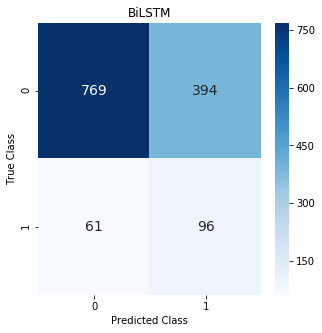

In [0]:
print(classification_report(Y_test.values, y_pred_bool))
results = confusion_matrix(Y_test.values, y_pred_bool)
# plt.figure(figsize = (5,5))
# sns.heatmap(results, annot=True,annot_kws={"size": 10}, fmt='g')
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('BiLSTM')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [43]:
f1_score(Y_test.values, y_pred_bool, average='macro')  

0.5342276018615385

## Analysing Missclassified Tweets BiLSTM


In [0]:
y_test = np.asarray(Y_test)
misclassified = np.where(y_test != y_pred_bool)

In [42]:
print(len(misclassified[0]), 'misclassifications')

455 misclassifications


In [0]:
limit = 10
counts = [0] *2
for index in misclassified[0]:
  if limit in counts:
    break
  #original not offensive (0), classified as offensive (1) 
  if y_test[index] == 0 and y_pred_bool[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original offensive (1), classified as not offensive (0)
  elif y_test[index] == 1 and y_pred_bool[index] == 0:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1

 @USER Time to vote and spit in the eye of all these liberals
preprocessed tweet
time vote spit eye liberals
computed prob:  [0.18082207] class predicted:  1
original class:  0
 @USER Another overdose nigga:(
preprocessed tweet
another overdose nigga
computed prob:  [0.2382804] class predicted:  1
original class:  0
 @USER @USER SERVES THE BASTARDS RIGHT!
preprocessed tweet
serve bastards right
computed prob:  [0.17301539] class predicted:  1
original class:  0
 @USER We are “Casually fucked”
preprocessed tweet
we casually fuck
computed prob:  [0.23539749] class predicted:  1
original class:  0
 @USER Behold all the conservatives who deliberately ignore the fact that the OK gesture USED TO BE benign but now is co-opted by racists to signal they're down with white supremacy. Much like swastikas were benign in Asian countries (&amp; still are) but were co-opted &amp; ruined by Nazis.
preprocessed tweet
behold conservatives deliberately ignore fact ok gesture use benign co opt racists sig